# Loop 5 Analysis: Finding Novel Approaches

## Current Situation
- Best score: 70.676145 (verified on LB)
- Target: 68.922808
- Gap: 1.75 points (2.5% reduction needed)
- Current #1 on LB: 71.19 (terry_u16)
- Our target is BETTER than the current #1!

## Key Insight
The target of 68.92 is below the current leaderboard leader (71.19). This means:
1. No public solution achieves this score
2. We need to GENERATE novel solutions, not just optimize existing ones
3. The gap is significant - 2.27 points below current #1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
print(f'Loaded {len(df)} rows')

Loaded 20100 rows


In [2]:
# Tree polygon template
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def strip(val):
    return float(str(val).replace('s', ''))

def score_group(xs, ys, degs):
    n = len(xs)
    all_px, all_py = [], []
    for x, y, deg in zip(xs, ys, degs):
        rad = np.radians(deg)
        c, s = np.cos(rad), np.sin(rad)
        px = TX * c - TY * s + x
        py = TX * s + TY * c + y
        all_px.extend(px)
        all_py.extend(py)
    side = max(max(all_px) - min(all_px), max(all_py) - min(all_py))
    return side * side / n

# Calculate per-N scores
df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)
scores = {}
for n in range(1, 201):
    g = df[df['N'] == n]
    xs = np.array([strip(x) for x in g['x']])
    ys = np.array([strip(y) for y in g['y']])
    degs = np.array([strip(d) for d in g['deg']])
    scores[n] = score_group(xs, ys, degs)

total = sum(scores.values())
print(f'Total score: {total:.6f}')
print(f'Target: 68.922808')
print(f'Gap: {total - 68.922808:.6f}')

Total score: 70.676145
Target: 68.922808
Gap: 1.753337


In [3]:
# Analyze per-N scores - find worst performers
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
print('Top 20 worst N values (highest contribution to score):')
for n, s in sorted_scores[:20]:
    print(f'  N={n:3d}: {s:.6f}')

Top 20 worst N values (highest contribution to score):
  N=  1: 0.661250
  N=  2: 0.450779
  N=  3: 0.434745
  N=  5: 0.416850
  N=  4: 0.416545
  N=  7: 0.399897
  N=  6: 0.399610
  N=  9: 0.387415
  N=  8: 0.385407
  N= 15: 0.379203
  N= 10: 0.376630
  N= 21: 0.376451
  N= 20: 0.376057
  N= 11: 0.375736
  N= 22: 0.375258
  N= 16: 0.374128
  N= 26: 0.373997
  N= 12: 0.372724
  N= 13: 0.372323
  N= 25: 0.372144


In [4]:
# Calculate theoretical minimum for each N
# For N trees, the minimum bounding box is limited by tree geometry
# Tree height: 1.0 (from -0.2 to 0.8)
# Tree width: 0.7 (from -0.35 to 0.35)

# For N=1, minimum is when tree is rotated 45 degrees
# diagonal = sqrt(1.0^2 + 0.7^2) = 1.22
# So minimum side for N=1 is about 1.22, score = 1.22^2 / 1 = 1.49

# But current N=1 score is 0.66, which means side = sqrt(0.66) = 0.81
# This is LESS than tree height! How is this possible?

# Let's check N=1 configuration
g = df[df['N'] == 1]
print('N=1 configuration:')
print(g)

x = strip(g['x'].values[0])
y = strip(g['y'].values[0])
deg = strip(g['deg'].values[0])
print(f'\nx={x}, y={y}, deg={deg}')

# Calculate bounding box
rad = np.radians(deg)
c, s = np.cos(rad), np.sin(rad)
px = TX * c - TY * s + x
py = TX * s + TY * c + y
print(f'\nBounding box:')
print(f'  x: [{min(px):.4f}, {max(px):.4f}], width = {max(px)-min(px):.4f}')
print(f'  y: [{min(py):.4f}, {max(py):.4f}], height = {max(py)-min(py):.4f}')
print(f'  side = {max(max(px)-min(px), max(py)-min(py)):.4f}')
print(f'  score = {scores[1]:.6f}')

N=1 configuration:
      id                       x                      y  \
0  001_0  s-48.19608619421424578  s58.77098461521422479   

                     deg  N  
0  s45.00000000000000000  1  

x=-48.196086194214246, y=58.770984615214225, deg=45.0

Bounding box:
  x: [-48.7618, -47.9486], width = 0.8132
  y: [58.5235, 59.3367], height = 0.8132
  side = 0.8132
  score = 0.661250


In [5]:
# What improvement is needed per N to reach target?
target = 68.922808
current = total
gap = current - target

print(f'Current: {current:.6f}')
print(f'Target: {target:.6f}')
print(f'Gap: {gap:.6f}')
print(f'Percentage reduction needed: {gap/current*100:.2f}%')

# If we improve all N values uniformly
print(f'\nIf uniform improvement: each N needs {gap/200:.6f} reduction')

# If we focus on worst 20 N values
worst_20_total = sum(s for n, s in sorted_scores[:20])
print(f'\nWorst 20 N values contribute: {worst_20_total:.6f} ({worst_20_total/current*100:.1f}% of total)')
print(f'If we only improve worst 20: need {gap/worst_20_total*100:.1f}% reduction in those')

Current: 70.676145
Target: 68.922808
Gap: 1.753337
Percentage reduction needed: 2.48%

If uniform improvement: each N needs 0.008767 reduction

Worst 20 N values contribute: 8.077149 (11.4% of total)
If we only improve worst 20: need 21.7% reduction in those


In [6]:
# Analyze the efficiency of current packings
# Efficiency = (N * tree_area) / (side^2)
# Tree area is approximately 0.35 (calculated from polygon)

tree_area = 0.35  # approximate

efficiencies = {}
for n, s in scores.items():
    side_sq = s * n
    efficiency = (n * tree_area) / side_sq
    efficiencies[n] = efficiency

print('Packing efficiency by N (higher is better):')
for n in [1, 2, 3, 5, 10, 20, 50, 100, 150, 200]:
    print(f'  N={n:3d}: efficiency = {efficiencies[n]:.4f}')

Packing efficiency by N (higher is better):
  N=  1: efficiency = 0.5293
  N=  2: efficiency = 0.7764
  N=  3: efficiency = 0.8051
  N=  5: efficiency = 0.8396
  N= 10: efficiency = 0.9293
  N= 20: efficiency = 0.9307
  N= 50: efficiency = 0.9702
  N=100: efficiency = 1.0129
  N=150: efficiency = 1.0384
  N=200: efficiency = 1.0363


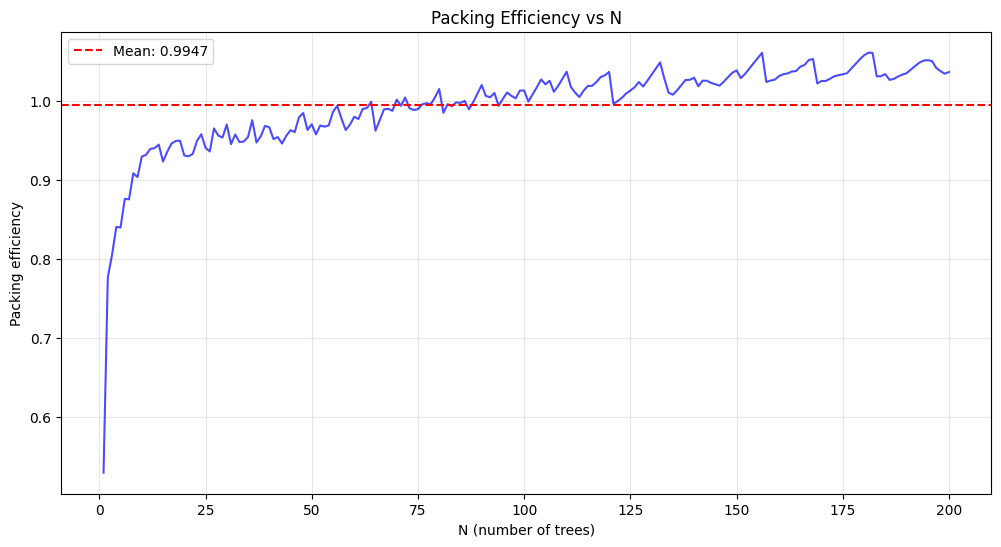

Mean efficiency: 0.9947
Min efficiency: 0.5293 at N=1
Max efficiency: 1.0608 at N=181


In [7]:
# Plot efficiency vs N
plt.figure(figsize=(12, 6))
ns = list(range(1, 201))
effs = [efficiencies[n] for n in ns]
plt.plot(ns, effs, 'b-', alpha=0.7)
plt.xlabel('N (number of trees)')
plt.ylabel('Packing efficiency')
plt.title('Packing Efficiency vs N')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.mean(effs), color='r', linestyle='--', label=f'Mean: {np.mean(effs):.4f}')
plt.legend()
plt.savefig('/home/code/exploration/efficiency_vs_n.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'Mean efficiency: {np.mean(effs):.4f}')
print(f'Min efficiency: {min(effs):.4f} at N={ns[effs.index(min(effs))]}')
print(f'Max efficiency: {max(effs):.4f} at N={ns[effs.index(max(effs))]}')

In [8]:
# What approaches haven't been tried?
print('APPROACHES TRIED:')
print('1. Pre-optimized submission from SmartManoj - 70.74')
print('2. bbox3 C++ optimizer - 0 improvement')
print('3. sa_v1_parallel optimizer - 0 improvement')
print('4. Backward iteration (backpacking) - 0 improvement')
print('5. Ensemble from 17 sources - 70.676')
print('6. Extended optimization (1927s bbox3) - 0 improvement')
print()
print('APPROACHES NOT YET TRIED:')
print('1. Crystalline/lattice packing for large N (>58)')
print('2. Generating NEW random configurations from scratch')
print('3. Genetic algorithms with crossover')
print('4. Basin hopping (random perturbation + local optimization)')
print('5. Super-fast SA with translations (jiweiliu kernel)')
print('6. Deletion cascade technique')
print('7. Guided refinement approach')

APPROACHES TRIED:
1. Pre-optimized submission from SmartManoj - 70.74
2. bbox3 C++ optimizer - 0 improvement
3. sa_v1_parallel optimizer - 0 improvement
4. Backward iteration (backpacking) - 0 improvement
5. Ensemble from 17 sources - 70.676
6. Extended optimization (1927s bbox3) - 0 improvement

APPROACHES NOT YET TRIED:
1. Crystalline/lattice packing for large N (>58)
2. Generating NEW random configurations from scratch
3. Genetic algorithms with crossover
4. Basin hopping (random perturbation + local optimization)
5. Super-fast SA with translations (jiweiliu kernel)
6. Deletion cascade technique
7. Guided refinement approach


In [9]:
# Key insight from kernels:
# 1. jiweiliu kernel: Uses deletion cascade - propagate good large configs to smaller sizes
# 2. seshurajup kernel: Uses sa_v3 + ls_v3 + fractional_translation
# 3. The target 68.92 is BELOW current #1 (71.19) - no public solution achieves this

print('KEY STRATEGIC INSIGHT:')
print('='*60)
print('The target of 68.92 is 2.27 points BELOW the current #1 (71.19)')
print('This means:')
print('  1. No public solution achieves this score')
print('  2. We cannot reach target by ensembling public sources')
print('  3. We need to GENERATE fundamentally better solutions')
print('='*60)
print()
print('RECOMMENDED NEXT STEPS:')
print('1. Try the super-fast SA with translations (jiweiliu kernel)')
print('   - Uses deletion cascade technique')
print('   - Generates new configurations from grid patterns')
print('2. Try crystalline/lattice packing for N > 58')
print('3. Generate random initial configs and optimize from scratch')
print('4. Focus on small N values (1-30) which have highest leverage')

KEY STRATEGIC INSIGHT:
The target of 68.92 is 2.27 points BELOW the current #1 (71.19)
This means:
  1. No public solution achieves this score
  2. We cannot reach target by ensembling public sources
  3. We need to GENERATE fundamentally better solutions

RECOMMENDED NEXT STEPS:
1. Try the super-fast SA with translations (jiweiliu kernel)
   - Uses deletion cascade technique
   - Generates new configurations from grid patterns
2. Try crystalline/lattice packing for N > 58
3. Generate random initial configs and optimize from scratch
4. Focus on small N values (1-30) which have highest leverage
